<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/Heat_equation_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook solves the polar heat equation in one dimension

$\rho c \frac{\partial T}{\partial t}=\frac{\partial k}{\partial r}\frac{\partial T}{\partial r}+\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$

With the assumption that $\frac{\partial k}{\partial r} = 0$, the equation simplifies to

$\rho c \frac{\partial T}{\partial t}=\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$

The initial condition is linearly interpolated from the measured core and bark temperatures at $t = 0$. Two boundary conditions are from the measured core and bark temperatures.

We aim to solve the inverse problem for determining the parameters in the original continuous PDE.

The inverse problem is formulated to be

$\frac{\partial T}{\partial t}=\lambda_1\frac{1}{r}\frac{\partial T}{\partial r}+\lambda_1\frac{\partial^2 T}{\partial r^2}+\lambda_2\text{ source term}$

and the Physics information is

$\text{residual} = \frac{\partial T}{\partial t}-\lambda_1\frac{1}{r}\frac{\partial T}{\partial r}-\lambda_1\frac{\partial^2 T}{\partial r^2}-\lambda_2\text{ solar radiation}-\lambda_3\text{ long radiation}-\lambda_4\text{ convection}$

We identify parameters $\lambda_j$, with a physcis informed neural network.

## Three terms are in the loss function, evaluated at ``X_r``, ``X_0``, and ``X_b``.

1. At ``X_r``: residual of the PDE is computed
2. At ``X_0``: error of measured and computed solution at initial condition is computed
3. At ``X_b``: error of measured and computed solution at boundary condition is computed

The three terms are then summed up to be in the loss function.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

from time import time
from IPython.display import clear_output

clear_output()

Set hyperparameters

In [2]:
# set data type and hyperparameters

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype = DTYPE)

# Set number of data points
N_0 = 412 # number of points in space; same as N_0 for simplicity
N_b = 412 # number of points in time; this is the amount of measurements in 24 hours
N_r = 1000

# Set boundary
tmin = 0.
tmax = 24.
xmin = 0.001
xmax = 0.135

# surface source to volume source
delta_r = (xmax - xmin) / N_b
coeff = 1. / delta_r

# heat parameters
sigma = 5.76e-8
albedo = 0.3

# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data; need N_0 == N_b for concat
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_init = tf.linspace(lb[1], ub[1], N_0)
x_0 = tf.reshape(x_init, (N_0,1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data- left to be core temperature, and right the bark temperature
t_boundary = tf.linspace(lb[0], ub[0], N_b)
t_b = tf.reshape(t_boundary, (N_b,1))
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)

## Add extra training data at X_train (location at midTemp1)
idx = int(N_0 / 3)
x_train = tf.ones((N_0,1), dtype=DTYPE) * x_init[idx]
X_train = tf.concat([t_b, x_train], axis=1)
x_train1 = tf.ones((N_0,1), dtype=DTYPE) * x_init[2 * idx]
X_train1 = tf.concat([t_b, x_train1], axis=1)


# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

### Visualize location of data points

Text(0.5, 1.0, 'Initial, boundary, and extra training data')

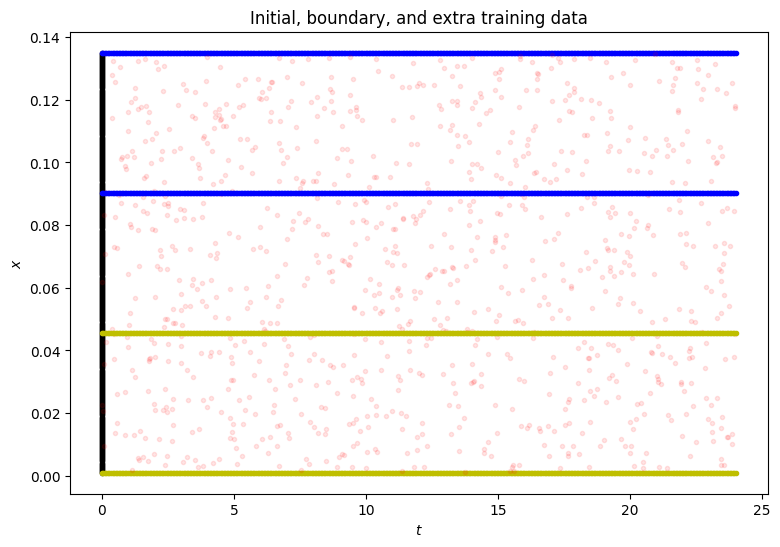

In [56]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c='k', marker='.')
plt.scatter(t_b, x_lb, c='y', marker='.')
plt.scatter(t_b, x_ub, c='b', marker='.')
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.scatter(t_b, x_train, c='y', marker='.')
plt.scatter(t_b, x_train1, c='b', marker='.')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Initial, boundary, and extra training data')

In [3]:
##### ave tree temp and weather temp for future reference
train_tree_temp_index = 416 - 2
train_interp_temp_size = train_tree_temp_index
test_tree_temp_index = 827 - 2
test_interp_temp_size = test_tree_temp_index - train_tree_temp_index

train_weather_index = 145 - 2
train_interp_weather_size = train_weather_index
test_weather_index = 289 -2
test_interp_weather_size = test_weather_index - train_weather_index
####

In [4]:
##### measured tree temperature for initial and boundary conditions. Need fixing
colnames_tree_temp = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
dataTemp = pandas.read_excel(url1,names=colnames_tree_temp)

### training temperature data
# core temp is west, at 13.5cm, at 2m high
train_coreTemp = np.array(dataTemp.s135_3[2: train_tree_temp_index])+ 273.15
# West, at 9cm, at 3m high
train_midTemp1 = np.array(dataTemp.w9_3[2: train_tree_temp_index])+ 273.15
# North, at 4.5cm, at 3m high
train_midTemp2 = np.array(dataTemp.n45_3[2: train_tree_temp_index])+ 273.15
# bark temp is West, at bark, at 3.5m high
train_barkTemp = np.array(dataTemp.w_ext_35[2: train_tree_temp_index])+ 273.15

train_initTemp = np.array([train_coreTemp[0], train_midTemp1[0], train_midTemp2[0], train_barkTemp[0]])
train_init_temp = np.interp(np.linspace(0,xmax,N_0), np.linspace(0,xmax,train_initTemp.size),train_initTemp)

### Initial and boundary conditions
# core temp is west, at 13.5cm, at 2m high
test_coreTemp = np.array(dataTemp.s135_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# West, at 9cm, at 3m high
test_midTemp1 = np.array(dataTemp.w9_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# North, at 4.5cm, at 3m high
test_midTemp2 = np.array(dataTemp.n45_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# bark temp is West, at bark, at 3.5m high
test_barkTemp = np.array(dataTemp.w_ext_35[train_tree_temp_index: test_tree_temp_index])+ 273.15

test_initTemp = np.array([test_coreTemp[0], test_midTemp1[0], test_midTemp2[0], test_barkTemp[0]])
test_init_temp = np.interp(np.linspace(0,xmax,N_0), np.linspace(0,xmax,test_initTemp.size),test_initTemp)

Rename variables to be easy to read.

In [5]:
u_0 = train_init_temp
u_lb = train_coreTemp
u_ub = train_barkTemp
u_train = train_midTemp1
u_train1 = train_midTemp2

# collect initial and two boundary data in lists # add training data and points
X_data = [X_0, X_lb, X_ub, X_train, X_train1]
u_data = [u_0, u_lb, u_ub, u_train, u_train1]
#  attach more term X_data = [X_0, X_lb, X_ub, X_train, X_train1]

# test by printing length of u_0, and u_lb
print(len(u_0))
print(len(u_lb))

412
412


Read in weather data, make source term

In [6]:
colnames_weather = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
dataWeather = pandas.read_excel(url2,names=colnames_weather)

nu = 15.89e-6 # m^2/s kinematic viscosity of air
Pr = 0.707
ka = 26.3e-3 # W/mK conductivity of air
coeff = 2 * xmax / nu

#### training
# wind speed from Oct 21
train_windSpeed = np.array(dataWeather.wind_speed[:train_weather_index])
# humidity from Oct 21
train_humidity = np.array(dataWeather.humidity[:train_weather_index])
# air temperature from Oct 21
train_airTemp = np.array(dataWeather.air_temperature[:train_weather_index])+ 273.15
# air pressure from Oct 21
train_airPressure = np.array(dataWeather.air_pressure[:train_weather_index])
# solar radiation from Oct 21
train_solar = np.array(dataWeather.solar_DNI[:train_weather_index])

train_airTemp = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_airTemp)
train_windSpeed = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_windSpeed)
train_solar = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_solar)



Re_train = train_windSpeed * coeff
C_train = []
m_train = []
for j in range(train_windSpeed.size):
    temp = Re_train[j]
    if temp < 0.4:
        temp1 = [0, 0]
    if 0.4<=temp<= 4:
        temp1 = [0.989, 0.330]
    if 4<temp<= 40:
        temp1 = [0.911, 0.385]
    if 40<temp<= 4e3:
        temp1 = [0.683, 0.466]
    if 4e3<temp<= 4e4:
        temp1 = [0.193, 0.618]
    if 4e4<temp<= 4e5:
        temp1 = [0.027, 0.805]
    C_train.append(temp1[0])
    m_train.append(temp1[1])

Nu_train = C_train * Re_train ** m_train * Pr ** (1/3)
h_train = Nu_train * ka / (2 * xmax)

convect_train = h_train * (u_ub - train_airTemp)
sourceTerm_train = (1 - albedo) * train_solar + sigma * (train_airTemp**4 - u_ub**4) + convect_train

# introduce lambd_3, and lambd_4
# sourceTerm_train = lambd_2 * train_solar + lambd_3 * (train_airTemp**4 - u_ub**4) + lambd_4 * (u_ub - train_airTemp)

## Here we try inference setting, without class implementation

We use known coefficients for $k$, $c$, and $\rho$.

thermal_conductivity = 0.16 # Notation k in paper # pg 3-17, wood handbook.
rho = 720 # kg /m**3
specific_heat = 1300 # table 3-12, at 27 degrees, MC 12% (wood handbook)

In [61]:
k = 0.16
c = 1300
rho = 720

In [62]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

In [63]:
# Define residual of the cylinder PDE at interior and the boundary
def fun_r_boundary(x, u, u_t, u_x, u_xx):
    return rho * c * u_t - k/x * u_x - k * u_xx - delta_r * sourceTerm_train

def fun_r_interior(x, u, u_t, u_x, u_xx):
    return rho * c * u_t - k/x * u_x - k * u_xx

In [64]:
# # Define residual of the rectangular PDE interior and boundary
# coeff = delta_r # 1, delta_r, 1./ delta_r, -1
# def fun_r_boundary(x, u, u_t, u_x, u_xx):
#     return  u_t - k/(rho * c) * u_xx - coeff * sourceTerm_train

# def fun_r_interior(x, u, u_t, u_x, u_xx):
#     return u_t - k/(rho * c) * u_xx

In [65]:
# compute residual at the outer boundary
def get_r_boundary(model, X_ub):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_ub[:, 0:1], X_ub[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r_boundary(x, u, u_t, u_x, u_xx)

#########################################################################
def get_r_interior(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r_interior(x, u, u_t, u_x, u_xx)

In [66]:
def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r_interior(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    # Initialize loss with interior residual
    loss = phi_r
    # X_data[2] is X_ub
    r_boundary = get_r_boundary(model, X_data[2])
    phi_r_boundary = tf.reduce_mean(tf.square(r_boundary))
    # add boundary residual with surface source term
    loss += phi_r_boundary

    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

In [67]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [68]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
lr = 1e-1

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [72]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.15836782e+01
It 00050: loss = 1.15836782e+01
It 00100: loss = 1.15836763e+01
It 00150: loss = 1.15836763e+01
It 00200: loss = 1.15836763e+01
It 00250: loss = 1.15836763e+01
It 00300: loss = 1.15836763e+01
It 00350: loss = 1.15836821e+01
It 00400: loss = 1.15836821e+01
It 00450: loss = 1.15836792e+01
It 00500: loss = 1.15836792e+01
It 00550: loss = 1.15836792e+01
It 00600: loss = 1.15836792e+01
It 00650: loss = 1.15836763e+01
It 00700: loss = 1.15836821e+01
It 00750: loss = 1.15836821e+01
It 00800: loss = 1.15836821e+01
It 00850: loss = 1.15836763e+01
It 00900: loss = 1.15836830e+01
It 00950: loss = 1.15836763e+01
It 01000: loss = 1.15836821e+01
It 01050: loss = 1.15836821e+01
It 01100: loss = 1.15836773e+01
It 01150: loss = 1.15836782e+01
It 01200: loss = 1.15836763e+01
It 01250: loss = 1.15836763e+01
It 01300: loss = 1.15836782e+01
It 01350: loss = 1.15836763e+01
It 01400: loss = 1.15836773e+01
It 01450: loss = 1.15836782e+01
It 01500: loss = 1.15836763e+01
It 01550

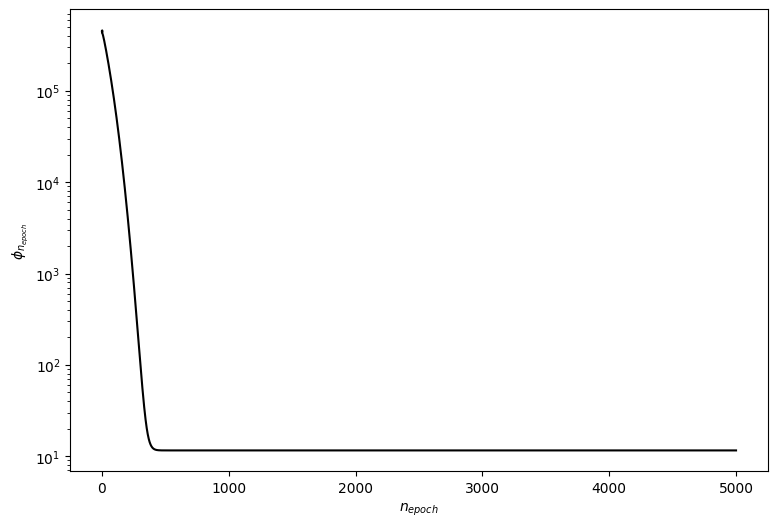

In [70]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

# RUN ABOVE FOR INFERENCE SETTING



In [ ]:
## Define test data

#### training
# wind speed from Oct 21
test_windSpeed = np.array(dataWeather.wind_speed[train_weather_index:test_weather_index])
# humidity from Oct 21
test_humidity = np.array(dataWeather.humidity[train_weather_index:test_weather_index])
# air temperature from Oct 21
test_airTemp = np.array(dataWeather.air_temperature[train_weather_index:test_weather_index])+ 273.15
# air pressure from Oct 21
test_airPressure = np.array(dataWeather.air_pressure[train_weather_index:test_weather_index])
# solar radiation from Oct 21
test_solar = np.array(dataWeather.solar_DNI[train_weather_index:test_weather_index])

test_airTemp = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,test_interp_weather_size),test_airTemp)
test_windSpeed = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,test_interp_weather_size),test_windSpeed)
test_solar = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,test_interp_weather_size),test_solar)



Re_test = test_windSpeed * coeff
C_test = []
m_test = []
for j in range(test_windSpeed.size):
    temp = Re_test[j]
    if temp < 0.4:
        temp1 = [0, 0]
    if 0.4<=temp<= 4:
        temp1 = [0.989, 0.330]
    if 4<temp<= 40:
        temp1 = [0.911, 0.385]
    if 40<temp<= 4e3:
        temp1 = [0.683, 0.466]
    if 4e3<temp<= 4e4:
        temp1 = [0.193, 0.618]
    if 4e4<temp<= 4e5:
        temp1 = [0.027, 0.805]
    C_test.append(temp1[0])
    m_test.append(temp1[1])

Nu_test = C_test * Re_test ** m_test * Pr ** (1/3)
h_test = Nu_test * ka / (2 * xmax)

convect_test = h_test * (u_ub - test_airTemp)
sourceTerm_test = (1 - albedo) * test_solar + sigma * (test_airTemp**4 - u_ub**4) + convect_test

Text(0.5, 1.0, 'Source term')

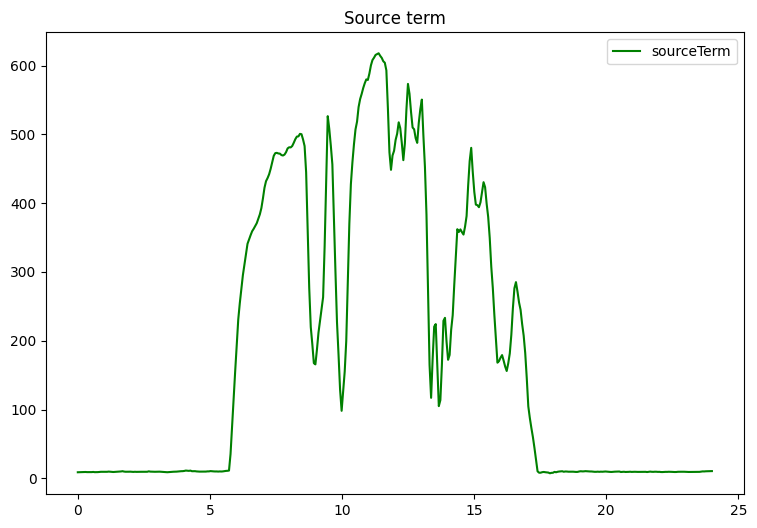

In [7]:
# visualize sourceTerm to compare with cell_test
fig137 = plt.figure(figsize=(9,6))
plt.plot(t_b, sourceTerm_train, color='green', label='sourceTerm')

plt.legend()
plt.title("Source term")

Text(0.5, 1.0, 'Boundary temperature at the core')

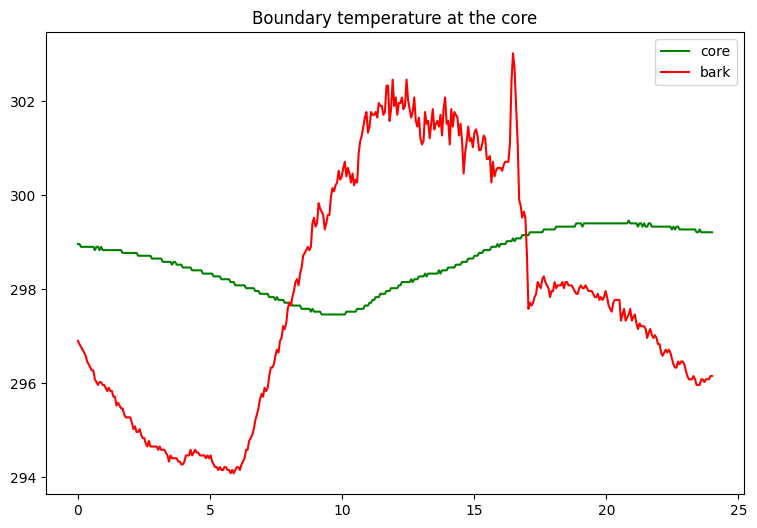

In [8]:
# visualize the boundary conditions.
fig1 = plt.figure(figsize=(9,6))
plt.plot(t_b, u_lb, color='green', label='core')
plt.plot(t_b, u_ub, color='red', label='bark')
plt.legend()
plt.title("Boundary temperature at the core")

Text(0.5, 1.0, 'Initial temperature distribution in tree trunk')

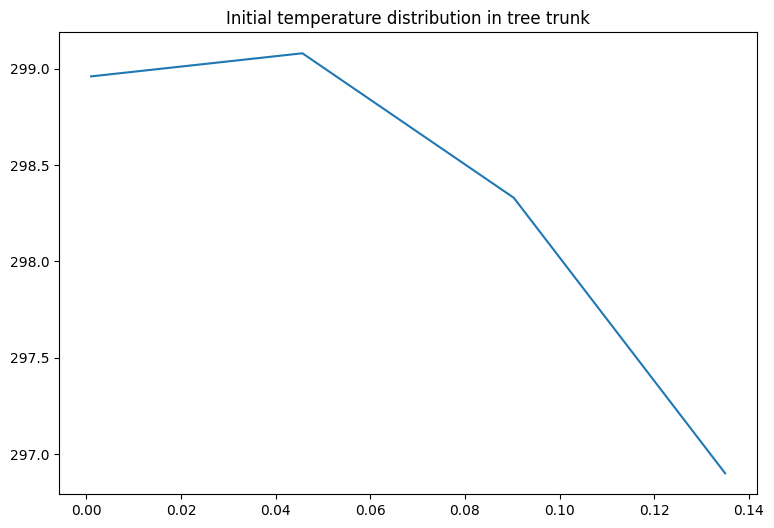

In [9]:
# visualize the initial condition.
fig2 = plt.figure(figsize=(9,6))
plt.plot(x_0, u_0, label = 'initial temp')
plt.legend
plt.title("Initial temperature distribution in tree trunk")

Plot initial and boundary data, and collocation data in time space.

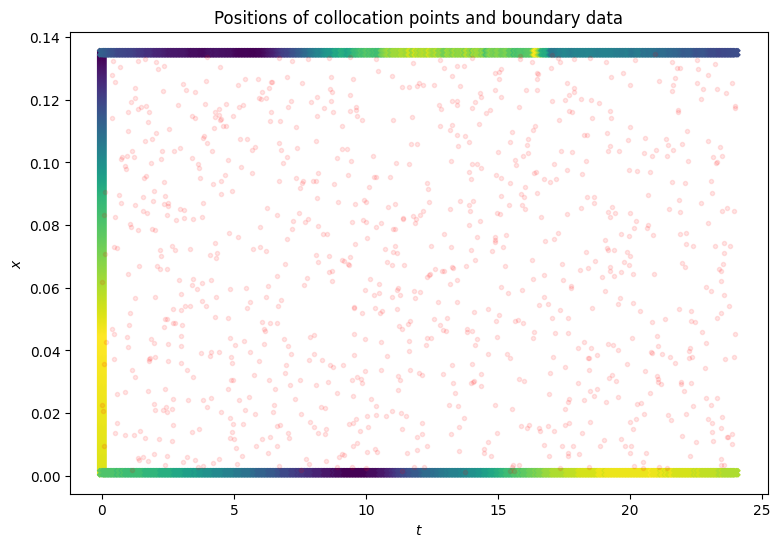

In [10]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=u_0.min(), vmax=u_0.max())
plt.scatter(t_b, x_lb, c=u_lb, marker='X', vmin=u_lb.min(), vmax=u_lb.max())
plt.scatter(t_b, x_ub, c=u_ub, marker='X', vmin=u_ub.min(), vmax=u_ub.max())
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_heat.pdf', bbox_inches='tight', dpi=300)

# RUN BELOW FOR IDENTIFICATION SETTING

Class implementation of PINN. Derive `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`. This is a general neural net that is equation independent.

In [11]:
# Define model architecture

class PINN_NeuralNet(tf.keras.Model):
  """Basic architecture of the PINN model
  """

  def __init__(self, lb, ub,
               output_dim = 1,
               num_hidden_layers = 8,
               num_neurons_per_layer = 20,
               activation = 'tanh',
               kernel_initializer = 'glorot_normal',
               **kwargs):
    super().__init__(**kwargs)

    self.num_hidden_layers = num_hidden_layers
    self.output_dim = output_dim
    self.lb = lb
    self.ub = ub

    # Define NN architecture
    self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
    self.out = tf.keras.layers.Dense(output_dim)

  def call(self, X):
    """
    Forward-pass thru NN
    """
    Z = self.scale(X)
    for i in range(self.num_hidden_layers):
      Z = self.hidden[i](Z)
    return self.out(Z)

Derive from the above neural net class to take in additional parameters `lambd1`, `lambd2`.

In [12]:
class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):

        # Call init of base class
        super().__init__(*args,**kwargs)

        # Initialize variable for lambda
        # initial guess: lambd1 = 0.16 / (720 * 1300), lambd2 = 1.0 / (720 * 1300)

        self.lambd1 = tf.Variable(0.3/(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd1_list = []

        self.lambd2 = tf.Variable(1./(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd2_list = []

        self.lambd3 = tf.Variable(0.3/(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd3_list = []

        self.lambd4 = tf.Variable(1./(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd4_list = []

Define base class `PINNSolver`. This is equation dependent. Components to customize are

1. get_r <---- modify what derivatives are computed
2. loss_fn <--- modify the boundary conditions
3. fun_r <--- residual of the PDE
4. should check all functions if boundary data were changed

Here we only consider the method based on tensorflow optimizer object as input. The [original notebook](https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb#scrollTo=wcOkamgfZEks) though, also has method based on SciPy's LBFGS method.

In [18]:
class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points, separate t and x
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx) ########


    def loss_fn(self, X, u):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss


    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g


    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        ## introduce lambd_3, lambd_4 and separate sourceTerm_train
        sourceTerm_train = self.model.lambd2 * train_solar + self.model.lambd3 * (train_airTemp**4 - u_ub**4) + self.model.lambd4 * convect_train
        return u_t - self.model.lambd1 * 1./ x * u_x - self.model.lambd1 * u_xx - self.model.lambd2 * sourceTerm_train

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def callback(self, xr=None):
        lambd1 = self.model.lambd1.numpy()
        self.model.lambd1_list.append(lambd1)

        lambd2 = self.model.lambd2.numpy()
        self.model.lambd2_list.append(lambd2)

        lambd3 = self.model.lambd3.numpy()
        self.model.lambd1_list.append(lambd1)

        lambd4 = self.model.lambd4.numpy()
        self.model.lambd2_list.append(lambd2)


        if self.iter % 100 == 0:
            print('It {:05d}: loss = {:10.8e} lambda1 = {:10.8e} lambda2 = {:10.8e} lambda3 = {:10.8e} lambda4 = {:10.8e}'.format(self.iter, self.current_loss, lambd1, lambd2, lambd3, lambd4))

        self.hist.append(self.current_loss)
        self.iter += 1


    def plot_solution(self, **kwargs):
        N = 411
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N,N)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_{\theta}(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        # color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd1_list,'-',color='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd2_list,'-',color='tab:red')
        ax2.plot(range(len(self.hist)), self.model.lambd3_list,'-',color='tab:green')
        ax2.plot(range(len(self.hist)), self.model.lambd4_list,'-',color='tab:black')
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color='tab:blue')
        return (ax1,ax2)

Initialize model and solver.

In [19]:
# initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=2)
model.build(input_shape=(None,2))

# initialize PINN solver
solver = PINNSolver(model, X_r)

Start training

In [23]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

EPOCH = 6000

# start timer
t0 = time()

solver.solve_with_TFoptimizer(optim, X_data, u_data, N=EPOCH)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 18000: loss = 1.15757942e+01 lambda1 = -9.28275660e-03 lambda2 = 0.00000000e+00 lambda3 = -6.90768333e-03 lambda4 = 2.88656484e-02
It 18100: loss = 1.15757999e+01 lambda1 = -9.28275660e-03 lambda2 = 0.00000000e+00 lambda3 = -6.90768333e-03 lambda4 = 2.88656484e-02
It 18200: loss = 1.15757980e+01 lambda1 = -9.28275660e-03 lambda2 = 0.00000000e+00 lambda3 = -6.90768333e-03 lambda4 = 2.88656484e-02
It 18300: loss = 1.15757914e+01 lambda1 = -9.28275660e-03 lambda2 = 0.00000000e+00 lambda3 = -6.90768333e-03 lambda4 = 2.88656484e-02
It 18400: loss = 1.15757923e+01 lambda1 = -9.28275660e-03 lambda2 = 0.00000000e+00 lambda3 = -6.90768333e-03 lambda4 = 2.88656484e-02
It 18500: loss = 1.15757942e+01 lambda1 = -9.28275660e-03 lambda2 = 0.00000000e+00 lambda3 = -6.90768333e-03 lambda4 = 2.88656484e-02
It 18600: loss = 1.15757980e+01 lambda1 = -9.28275660e-03 lambda2 = 0.00000000e+00 lambda3 = -6.90768333e-03 lambda4 = 2.88656484e-02
It 18700: loss = 1.15757933e+01 lambda1 = -9.28275660e-03 lamb

Plot solution and loss history

In [ ]:
solver.plot_solution();


In [ ]:

solver.plot_loss_history();


In [ ]:

solver.plot_loss_and_param();

# Cells below replace cells after "Class implementation of PINN..."

## As of now, the error in computation seems more like coding error (1e5) rather than logic error (expected 1e0), so we work on the following methods to debug

Write a simplified forward problem; eliminate parameter identification problem, and use $\lambda_1$ and $\lambda_2$ that worked for FD problem in cell_test. These values should be

$\lambda_1=k/\rho c=0.3/(1.38 * 510)$ and $\lambda_2=1/\rho c=0.3/(1.38 * 510)$. We will see if the errors are still very big.

The code below is modified from

https://github.com/yajuna/tensorflow_pde/blob/master/Simple_PDE_with_tensorflow.ipynb


In [ ]:
lambd1 = 0.3/(1.38 * 510)
lambd2 = 1./(1.38 * 510)

In [ ]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model


In [ ]:
def get_r(model, X_r)-> tf.Tensor:

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)

    u_xx = tape.gradient(u_x, x)

    del tape

    return u_t - 1./x * lambd1 * u_x - lambd1 * u_xx - lambd2 * sourceTerm_train

In [ ]:
model = init_model(num_hidden_layers = 2)
r = get_r(model, X_0)
phi_r = tf.reduce_mean(tf.square(r))
loss = phi_r

print(X_0.shape)
print(X_0[1].shape)


In [ ]:
def compute_loss(model, X_r, X_data, u_data)-> tf.Tensor:

    # Compute phi^r-- physics informed loss
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add initial error loss; add boundary loss

    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

        return loss

    ## define customized loss-- max(abs(u_data and u_pred))


    return loss

In [ ]:
loss = compute_loss(model, X_r, X_data, u_data)

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
# Initialize model aka u_\theta
model = init_model(num_hidden_layers = 2)
# print(model.layers[0].input_shape)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step()-> tf.Tensor:
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
EPOCH = 50000
hist = []

# Start timer
t0 = time()

for i in range(EPOCH+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

In [ ]:
# Interactive plotting tools
# visualization tools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Tuple, Iterable

N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)

Xgrid = np.vstack([T.flatten(),X.flatten()]).T
# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# draw plane
surface = go.Surface(x=T, y=X, z=U, colorscale="phase", showscale=False)

# create figure
fig317 = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])
fig317.add_trace(surface, row=1, col=1)

fig317.show()

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');


In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# # Set up meshgrid
# N = 600
# tspace = np.linspace(lb[0], ub[0], N + 1)
# xspace = np.linspace(lb[1], ub[1], N + 1)
# T, X = np.meshgrid(tspace, xspace)
# Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# # Determine predictions of u(t, x)
# upred = model(tf.cast(Xgrid,DTYPE))

# # Reshape upred
# U = upred.numpy().reshape(N+1,N+1)

# # Surface plot of solution u(t,x)
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(T, X, U, cmap='viridis');
# ax.view_init(40,40)
# ax.set_xlabel('$t$')
# ax.set_ylabel('$x$')
# ax.set_zlabel('$u_{\theta}(t,x)$')
# ax.set_title('Solution of heat equation');
# #plt.savefig('wave_Solution.pdf', bbox_inches='tight', dpi=300);
